In [1]:
#vae.py
import os
import sys
import numpy as np

from keras.models import Model
from keras import backend as K
from keras.regularizers import l1
from keras.utils import plot_model
from keras.datasets import mnist, cifar10
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, Dropout
from keras.losses import mse, binary_crossentropy, kullback_leibler_divergence
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D

%matplotlib inline
import matplotlib.pyplot as plt

# ML4CVD Imports
from ml4cvd.arguments import parse_args
from ml4cvd.models import make_multimodal_multitask_new, train_model_from_generators
from ml4cvd.tensor_generators import big_batch_from_minibatch_generator, test_train_valid_tensor_generators

MRI_TENSORS = '/mnt/disks/lax-sax-ecg-ttn/2017-07-30/'

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [2]:
sys.argv = ['train', 
            '--tensors', MRI_TENSORS, 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'mri_slice',
            '--batch_size', '16',
            '--epochs', '8',
            '--conv_dropout', '0.1',
            '--learning_rate', '0.001',
            '--training_steps', '64',
            '--validation_steps', '4',
            '--test_steps', '1',
            '--id', 'mri_slice_vae']
args = parse_args()
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,  args.tensor_maps_out,  args.tensors, args.batch_size,   args.valid_ratio, args.test_ratio, args.test_modulo, args.balance_csvs)
model = make_multimodal_multitask_new(**args.__dict__)
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-09-18 17:27:39,091 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_slice_vae/log_2019-09-18_17-27_0.log.
2019-09-18 17:27:39,092 - arguments:187 - INFO - Command Line was:

./scripts/tf.sh train --tensors /mnt/disks/lax-sax-ecg-ttn/2017-07-30/ --input_tensors mri_slice --output_tensors mri_slice --batch_size 16 --epochs 2 --conv_dropout 0.2 --learning_rate 0.001 --training_steps 32 --validation_steps 4 --test_steps 1 --id mri_slice_vae



2019-09-18 17:27:39,093 - arguments:188 - INFO - Total TensorMaps:6261 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[], continuous_field_ids=[], conv_bn=False, conv_dilate=False, conv_dropout=0.2, conv_layers=[32]

2019-09-18 17:27:39,870 - tensor_generators:393 - INFO - Got first error: KeyError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 83, in multimodal_multitask_generator
    in_batch[tm.input_name()][stats['batch_index']] = tm.tensor_from_file(tm, hd5, dependents)
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/TensorMap.py", line 536, in _default_tensor_from_file
    cur_slice = np.random.choice(list(hd5[MRI_TO_SEGMENT].keys()))
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/group.py", line 262, in __getitem__
    oid = h5o.open(self.id, self._e(name), lapl=self._lapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5

In [3]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    #epsilon = K.random_normal(shape=(K.shape(z_mean)+(dim,)))
    epsilon = K.random_normal(shape=(K.shape(z_mean)))
    #epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
# VAE model = encoder + decoder
# network parameters
input_shape = (args.tensor_maps_in[0].shape)
original_dim = np.prod(input_shape)
latent_dim = 8

# build encoder model
inputs = Input(shape=input_shape, name=args.tensor_maps_in[0].input_name())
x = Conv2D(256, 3, strides=2, activation='relu', padding='same')(inputs)
x = Dropout(args.conv_dropout)(x)
x = Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
x = Dropout(args.conv_dropout)(x)
x = Conv2D(96, 3, strides=2, activation='relu', padding='same')(x)
x = Dropout(args.conv_dropout)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Dropout(args.conv_dropout)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
#z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

inner_shape = (32, 32, latent_dim)

# build decoder model
latent_inputs = Input(shape=inner_shape, name='z_sampling')
x = Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(latent_inputs)
x = Conv2DTranspose(96, 3, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(160, 3, activation='relu', padding='same')(x)
outputs = Conv2D(1, 1, activation='linear')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name=args.tensor_maps_out[0].output_name())
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mri_slice (InputLayer)    (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 256 2560        input_mri_slice[0][0]            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 256 0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 64, 64, 128)  295040      dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [8]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_cnn')
vae.summary()

# Compute VAE loss
def vae_loss(y_true, y_pred):
    #reconstruction_loss = binary_crossentropy(y_true, y_pred) * original_dim
    reconstruction_loss = mse(y_true, y_pred) * original_dim
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(K.mean(reconstruction_loss) + kl_loss)
    return vae_loss
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()

vae.fit_generator(generate_train, steps_per_epoch=args.training_steps, epochs=args.epochs, verbose=1,
                 validation_steps=args.validation_steps, validation_data=generate_valid)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_mri_slice (InputLayer) (None, 256, 256, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 32, 32, 8), (None 464688    
_________________________________________________________________
output_mri_slice (Model)     (None, 256, 256, 1)       355425    
Total params: 820,113
Trainable params: 820,113
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_mri_slice (InputLayer) (None, 256, 256, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 32, 32, 8), (None 464688    
_________________________________________________________________
outp

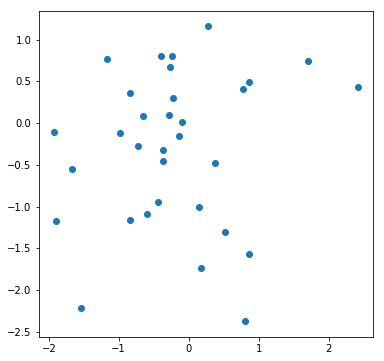

In [6]:
x_test_encoded = encoder.predict_generator(generate_test, steps=2)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2][:, 0, 0, 0], x_test_encoded[2][:, 0, 0, 1])
plt.show()

(16, 256, 256, 1)


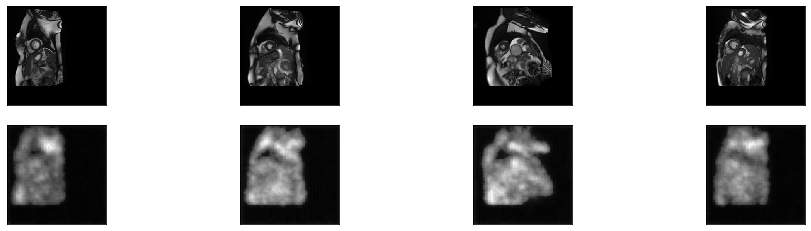

In [9]:
n = 4#batch_size  # how many digits we will display
image_shape = (256, 256)
plt.figure(figsize=(16, 4))
x_test = next(generate_test)
x_test_in = x_test[0][args.tensor_maps_in[0].input_name()]
x_test_out = x_test[1][args.tensor_maps_out[0].output_name()]

x_test_generated = vae.predict(x_test_in, batch_size=args.batch_size)
x_test_encoded = encoder.predict(x_test_in, batch_size=args.batch_size)
x_test_generated2 = decoder.predict(x_test_encoded[2])
print(x_test_generated2.shape)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_in[i].reshape(image_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_generated[i].reshape(image_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

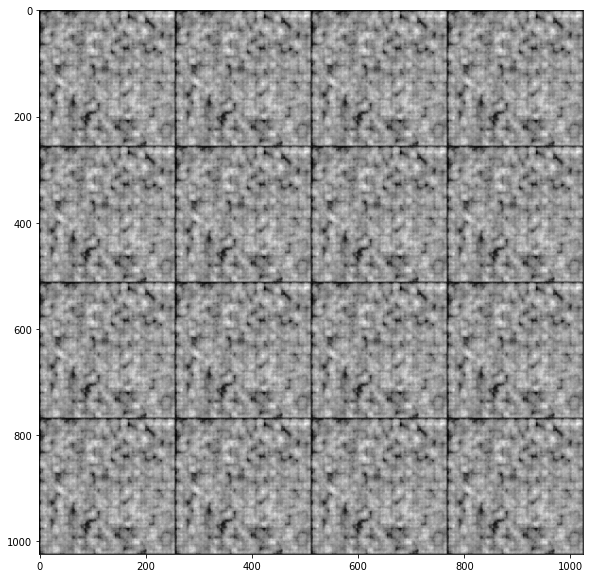

In [12]:
# display a 2D manifold of the digits
n = 4  # figure with 15x15 digits
digit_size = image_shape[0]
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(0, 1, n)
grid_y = np.linspace(0, 1, n)
corners = np.random.normal(size=(4, 1,) + inner_shape)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.zeros((1,) + inner_shape)
        z_sample[0, :, :, 6] = xi
        z_sample[0, :, :, 7] = yi
        z_sample = corners[0]*xi*yi + corners[0]*xi*(1-yi) + corners[0]*(1-xi)*yi + corners[0]*(1-xi)*(1-yi)
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(image_shape)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

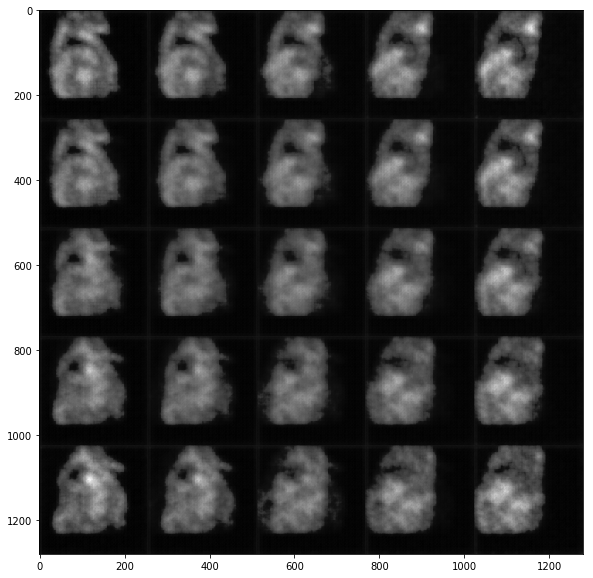

In [14]:
# display a 2D manifold of the digits
n = 5  # figure with 15x15 digits
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(0, 1, n)
grid_y = np.linspace(0, 1, n)
for i, alpha in enumerate(grid_x):
    for j, alpha2 in enumerate(grid_x):
        z = (alpha*alpha2*x_test_encoded[2][15])
        z += ((1-alpha)*alpha2*x_test_encoded[2][6])
        z += (alpha*(1-alpha2)*x_test_encoded[2][13])
        z += ((1-alpha)*(1-alpha2)*x_test_encoded[2][9])
        z = np.expand_dims(z, axis = 0)
        x_decoded = decoder.predict(z)
        digit = x_decoded[0].reshape(image_shape)
        figure[j * digit_size: (j + 1) * digit_size, i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()